In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [3]:
tf_download_root = "http://download.tensorflow.org/data/"
filename = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename,
                                   tf_download_root + filename,
                                   cache_dir=".",
                                   extract=True)

1065301781/1065301781 [==============================] - 93s 0us/step


In [5]:
from pathlib import Path


quickdraw_dir = Path(filepath).parent
train_files = sorted(
    [str(path) for path in quickdraw_dir.glob("training.tfrecord-*")]
)
eval_files = sorted(
    [str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")]
)

In [6]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [7]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [8]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [9]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [10]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

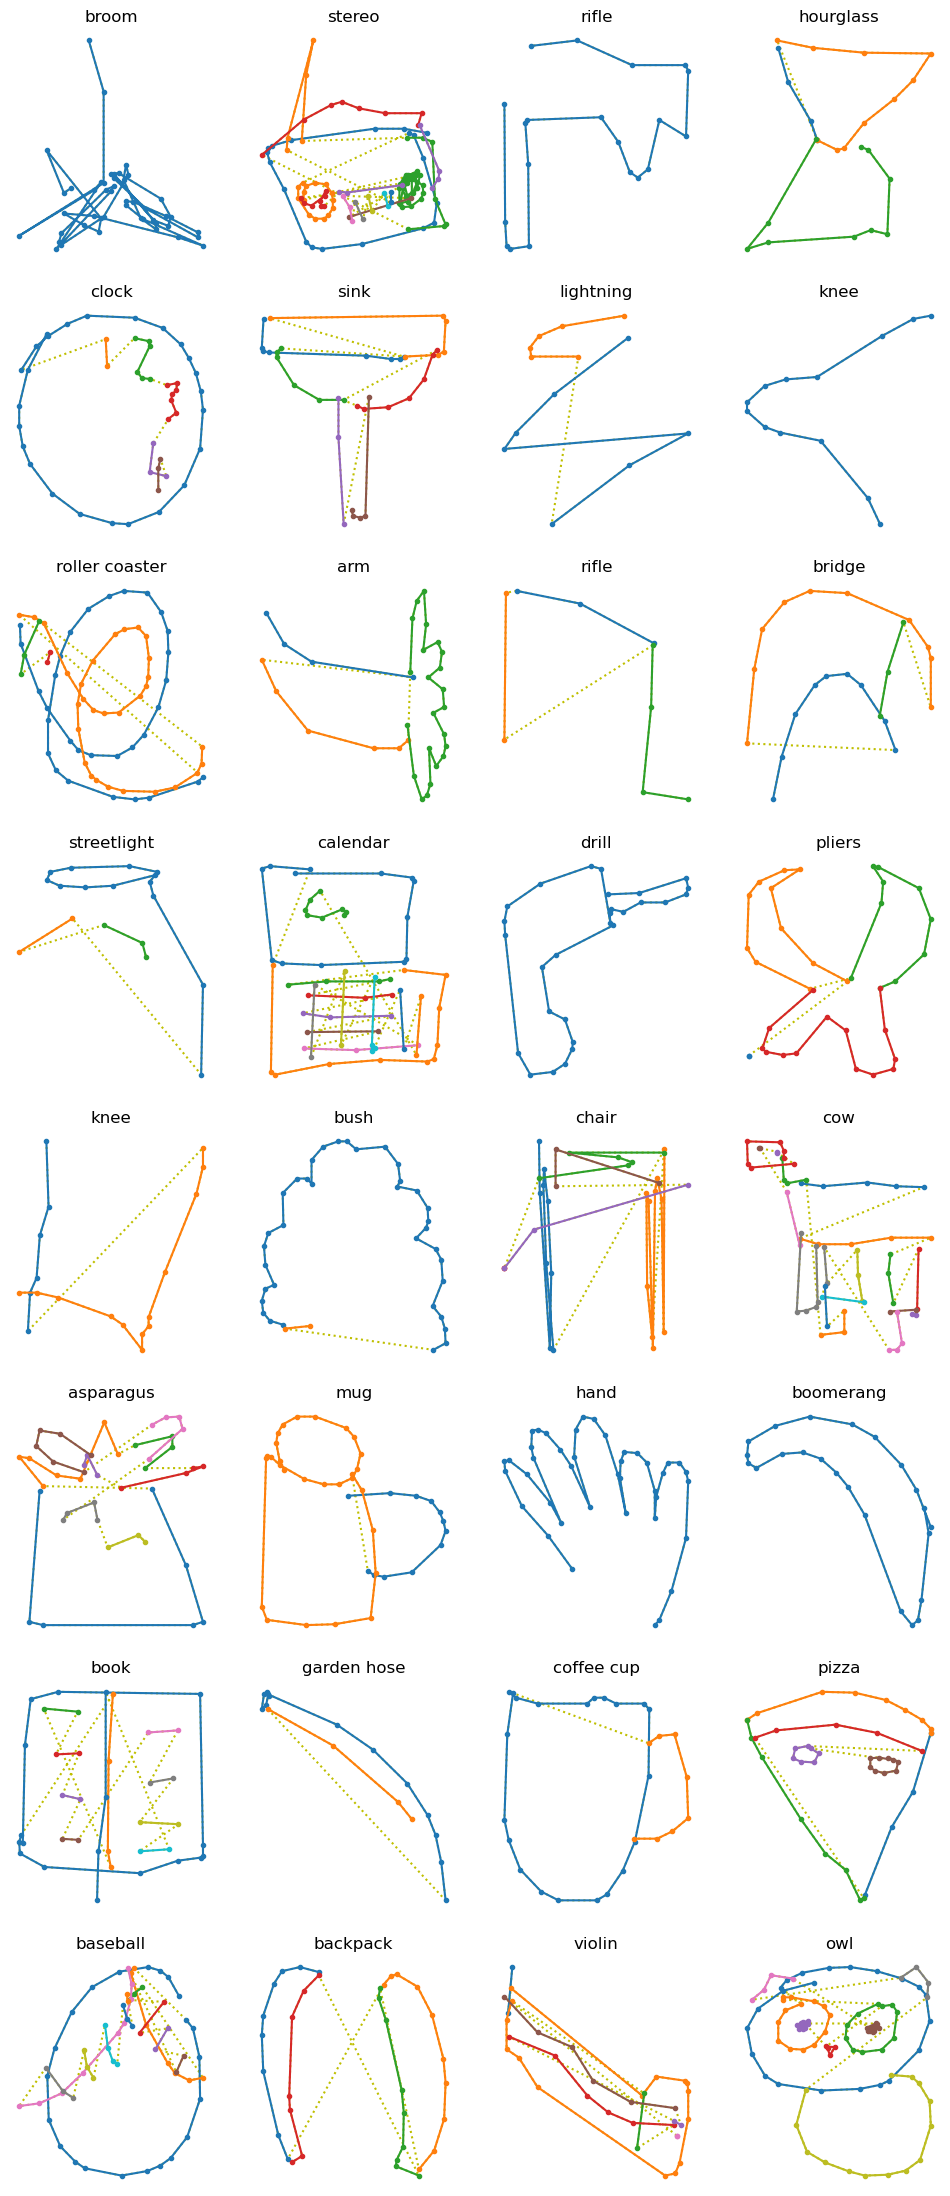

In [11]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = sketch[:, :2].cumsum(axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

In [12]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)


In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(len(class_names), activation="softmax")])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", 'sparse_top_k_categorical_accuracy'])

    

In [19]:
history = model.fit(cropped_train_set, epochs=5, validation_data=cropped_valid_set)

Epoch 1/5
  67389/Unknown - 865s 13ms/step - loss: 2.5055 - accuracy: 0.4198 - sparse_top_k_categorical_accuracy: 0.6942

KeyboardInterrupt: 

In [20]:
model.evaluate(cropped_test_set)

plt.plot(history.history["accuracy"], label="accuracy")

plt.plot(history.history["val_accuracy"], label="val_accuracy")

plt.legend()

plt.show()


5392/5392 [==============================] - 32s 6ms/step - loss: 1.8883 - accuracy: 0.5375 - sparse_top_k_categorical_accuracy: 0.8097


NameError: name 'history' is not defined

1/1 [==============================] - 1s 820ms/step


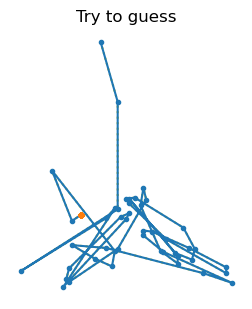

Top-5 predictions:
  1. broom 91.323%
  2. rake 1.633%
  3. ceiling fan 0.998%
  4. paintbrush 0.671%
  5. grapes 0.435%
Answer: broom


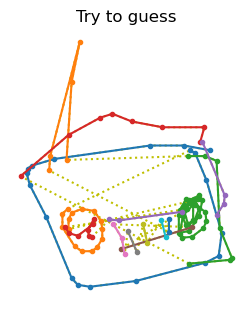

Top-5 predictions:
  1. radio 78.441%
  2. stereo 12.280%
  3. stove 0.841%
  4. belt 0.771%
  5. firetruck 0.514%
Answer: stereo


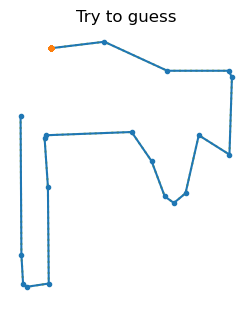

Top-5 predictions:
  1. rifle 80.461%
  2. drill 5.875%
  3. megaphone 2.883%
  4. bench 2.205%
  5. axe 1.159%
Answer: rifle


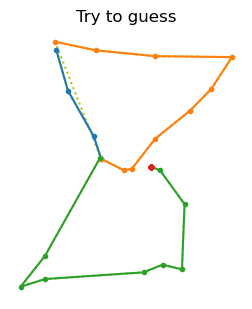

Top-5 predictions:
  1. anvil 34.193%
  2. hourglass 15.883%
  3. shovel 14.522%
  4. screwdriver 9.797%
  5. lipstick 6.139%
Answer: hourglass


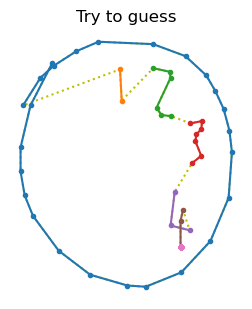

Top-5 predictions:
  1. clock 66.605%
  2. alarm clock 5.365%
  3. bracelet 5.022%
  4. compass 4.935%
  5. soccer ball 3.389%
Answer: clock


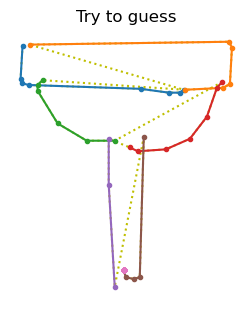

Top-5 predictions:
  1. table 19.389%
  2. mailbox 18.642%
  3. hammer 11.446%
  4. underwear 5.266%
  5. stop sign 4.636%
Answer: sink


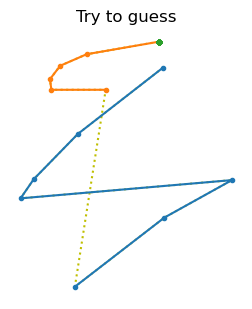

Top-5 predictions:
  1. lightning 50.398%
  2. zigzag 20.578%
  3. stairs 3.202%
  4. clarinet 2.242%
  5. hourglass 2.062%
Answer: lightning


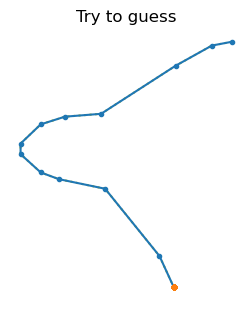

Top-5 predictions:
  1. knee 61.649%
  2. nose 15.727%
  3. boomerang 3.279%
  4. squiggle 2.139%
  5. elbow 2.132%
Answer: knee


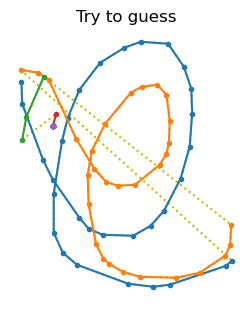

Top-5 predictions:
  1. roller coaster 75.551%
  2. watermelon 5.203%
  3. snail 4.348%
  4. steak 1.601%
  5. coffee cup 1.089%
Answer: roller coaster


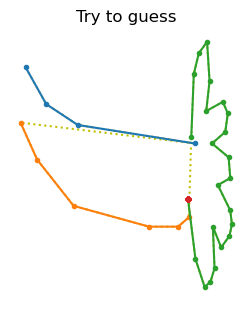

Top-5 predictions:
  1. arm 98.811%
  2. crocodile 0.611%
  3. speedboat 0.230%
  4. elbow 0.138%
  5. shark 0.021%
Answer: arm


In [21]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))